<a href="https://colab.research.google.com/github/moon2su/ML-programming/blob/main/BP_PPG_CNN_BiLSTM_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

In [ ]:
mat_path = "/content/drive/MyDrive/Colab Notebooks/BP/p087608.mat"

In [ ]:
def load_signals_from_mat(mat_path, num_samples = 5):
  """- parameters
  mat_path : .mat 파일 경로
  num_samples : 로드할 샘플 갯수"""

  # PPG(광용적 맥파), ABP(혈압 파형), ECG(심전도), SBP(수축기 혈압), DBP(이완기 혈압)
  signals = {'ppg': [], 'abp': [], 'ecg': [], 'sbp': [], 'dbp': []}

  with h5py.File(mat_path, 'r') as f:
    #데이터 참조 가져오기
    ppg_refs = f['Subj_Wins']['PPG_F'][0]
    abp_refs = f['Subj_Wins']['ABP_F'][0] if 'ABP_F' in f['Subj_Wins'] else None
    ecg_refs = f['Subj_Wins']['ECG_F'][0] if 'ECG_F' in f['Subj_Wins'] else None
    sbp_refs = f['Subj_Wins']['SegSBP'][0]
    dbp_refs = f['Subj_Wins']['SegDBP'][0]

    #지정된 개수만큼 로드
    total = min(len(ppg_refs), num_samples)

    for i in range(total):
      #PPG Signal
      ppg = f[ppg_refs[i]][()].squeeze().astype(np.float32)
      signals['ppg'].append(ppg)

      #ABP Signal (있는 경우)
      if abp_refs is not None:
        abp = f[abp_refs[i]][()].squeeze().astype(np.float32)
        signals['abp'].append(abp)

      #ECG Signal (있는 경우)
      if ecg_refs is not None:
        ecg = f[ecg_refs[i]][()].squeeze().astype(np.float32)
        signals['ecg'].append(ecg)

      # 혈압 타겟
      sbp = float(f[sbp_refs[i]][()][0][0])
      dbp = float(f[dbp_refs[i]][()][0][0])
      signals['sbp'].append(sbp)
      signals['dbp'].append(dbp)

  return signals

총 2000개의 세그먼트 로드 중...

=== 혈압 데이터 통계 ===
세그먼트 수: 2000

SBP (수축기 혈압):
  - 평균: 131.20 mmHg
  - 최소: 88.19 mmHg
  - 최대: 180.87 mmHg
  - 표준편차: 21.24 mmHg

DBP (이완기 혈압):
  - 평균: 59.02 mmHg
  - 최소: 42.81 mmHg
  - 최대: 82.25 mmHg
  - 표준편차: 8.79 mmHg


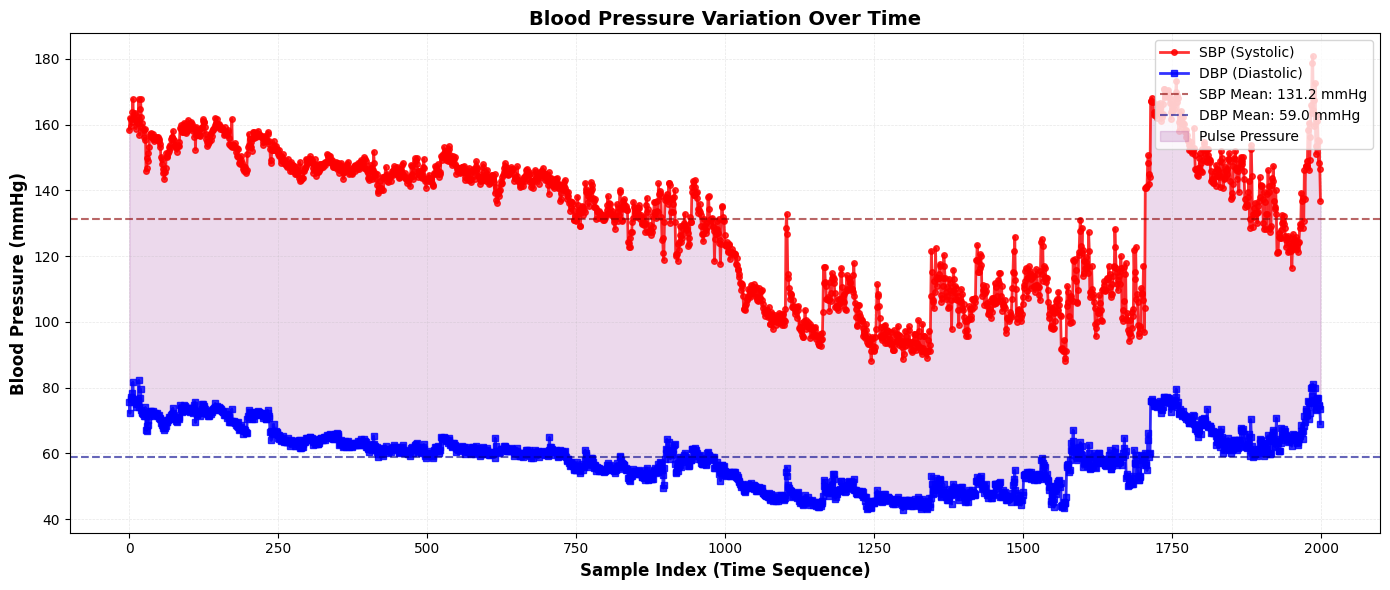


로드 완료: 2000개의 PPG 세그먼트


In [ ]:
def load_and_display_bp(mat_path, segment_limit=None):
    """
    MAT 파일에서 PPG 세그먼트와 혈압(SBP, DBP) 데이터를 로드하고 표시

    Args:
        mat_path: .mat 파일 경로
        segment_limit: 로드할 최대 세그먼트 수 (None이면 전체)
    """
    segments, sbp_list, dbp_list = [], [], []

    # MAT 파일 로드
    with h5py.File(mat_path, 'r') as f:
        refs = f['Subj_Wins']['PPG_F'][0]
        sbps = f['Subj_Wins']['SegSBP'][0]
        dbps = f['Subj_Wins']['SegDBP'][0]

        total = min(len(refs), segment_limit) if segment_limit else len(refs)

        print(f"총 {total}개의 세그먼트 로드 중...")

        for i in range(total):
            ppg = f[refs[i]][()].squeeze().astype(np.float32)
            sbp = float(f[sbps[i]][()][0][0])
            dbp = float(f[dbps[i]][()][0][0])

            segments.append(ppg)
            sbp_list.append(sbp)
            dbp_list.append(dbp)

    # 통계 출력
    print(f"\n=== 혈압 데이터 통계 ===")
    print(f"세그먼트 수: {len(segments)}")
    print(f"\nSBP (수축기 혈압):")
    print(f"  - 평균: {np.mean(sbp_list):.2f} mmHg")
    print(f"  - 최소: {np.min(sbp_list):.2f} mmHg")
    print(f"  - 최대: {np.max(sbp_list):.2f} mmHg")
    print(f"  - 표준편차: {np.std(sbp_list):.2f} mmHg")

    print(f"\nDBP (이완기 혈압):")
    print(f"  - 평균: {np.mean(dbp_list):.2f} mmHg")
    print(f"  - 최소: {np.min(dbp_list):.2f} mmHg")
    print(f"  - 최대: {np.max(dbp_list):.2f} mmHg")
    print(f"  - 표준편차: {np.std(dbp_list):.2f} mmHg")

    # 시각화
    plot_bp_combined_timeseries(sbp_list, dbp_list)

    return segments, sbp_list, dbp_list


def plot_bp_distribution(sbp_list, dbp_list):
    """혈압 분포 히스토그램"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.hist(sbp_list, bins=30, color='red', alpha=0.7, edgecolor='black')
    ax1.set_xlabel('SBP (mmHg)')
    ax1.set_ylabel('Frequency')
    ax1.set_title('SBP Distribution')
    ax1.axvline(np.mean(sbp_list), color='darkred', linestyle='--',
                linewidth=2, label=f'Mean: {np.mean(sbp_list):.1f}')
    ax1.legend()
    ax1.grid(alpha=0.3)

    ax2.hist(dbp_list, bins=30, color='blue', alpha=0.7, edgecolor='black')
    ax2.set_xlabel('DBP (mmHg)')
    ax2.set_ylabel('Frequency')
    ax2.set_title('DBP Distribution')
    ax2.axvline(np.mean(dbp_list), color='darkblue', linestyle='--',
                linewidth=2, label=f'Mean: {np.mean(dbp_list):.1f}')
    ax2.legend()
    ax2.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


def plot_bp_scatter(sbp_list, dbp_list):
    """SBP vs DBP 산점도"""
    plt.figure(figsize=(8, 6))
    plt.scatter(sbp_list, dbp_list, alpha=0.6, s=50, c=range(len(sbp_list)),
                cmap='viridis', edgecolors='black', linewidth=0.5)

    plt.xlabel('SBP (mmHg)', fontsize=12)
    plt.ylabel('DBP (mmHg)', fontsize=12)
    plt.title('SBP vs DBP Relationship', fontsize=14)
    plt.colorbar(label='Sample Index')
    plt.grid(alpha=0.3)

    # 추세선
    z = np.polyfit(sbp_list, dbp_list, 1)
    p = np.poly1d(z)
    plt.plot(sorted(sbp_list), p(sorted(sbp_list)), "r--",
             linewidth=2, label=f'Trend: y={z[0]:.2f}x+{z[1]:.2f}')
    plt.legend()

    plt.tight_layout()
    plt.show()


def plot_bp_timeseries(sbp_list, dbp_list):
    """시간 순서에 따른 SBP/DBP 변화 그래프"""
    time_idx = np.arange(len(sbp_list))

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

    # SBP 시계열
    ax1.plot(time_idx, sbp_list, color='red', linewidth=1.5,
             marker='o', markersize=3, alpha=0.7, label='SBP')
    ax1.axhline(np.mean(sbp_list), color='darkred', linestyle='--',
                linewidth=2, label=f'Mean: {np.mean(sbp_list):.1f}')
    ax1.fill_between(time_idx, sbp_list, alpha=0.2, color='red')
    ax1.set_ylabel('SBP (mmHg)', fontsize=12, fontweight='bold')
    ax1.set_title('Systolic Blood Pressure Over Time', fontsize=14)
    ax1.legend(loc='upper right')
    ax1.grid(alpha=0.3)

    # DBP 시계열
    ax2.plot(time_idx, dbp_list, color='blue', linewidth=1.5,
             marker='o', markersize=3, alpha=0.7, label='DBP')
    ax2.axhline(np.mean(dbp_list), color='darkblue', linestyle='--',
                linewidth=2, label=f'Mean: {np.mean(dbp_list):.1f}')
    ax2.fill_between(time_idx, dbp_list, alpha=0.2, color='blue')
    ax2.set_xlabel('Sample Index (Time Sequence)', fontsize=12)
    ax2.set_ylabel('DBP (mmHg)', fontsize=12, fontweight='bold')
    ax2.set_title('Diastolic Blood Pressure Over Time', fontsize=14)
    ax2.legend(loc='upper right')
    ax2.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


def plot_bp_combined_timeseries(sbp_list, dbp_list):
    """SBP와 DBP를 하나의 그래프에 표시 (흰색 배경)"""
    time_idx = np.arange(len(sbp_list))

    fig = plt.figure(figsize=(14, 6), facecolor='white')
    ax = fig.add_subplot(111, facecolor='white')

    # SBP와 DBP 라인 플롯
    ax.plot(time_idx, sbp_list, color='red', linewidth=2,
            marker='o', markersize=4, alpha=0.8, label='SBP (Systolic)')
    ax.plot(time_idx, dbp_list, color='blue', linewidth=2,
            marker='s', markersize=4, alpha=0.8, label='DBP (Diastolic)')

    # 평균선
    ax.axhline(np.mean(sbp_list), color='darkred', linestyle='--',
               linewidth=1.5, alpha=0.6, label=f'SBP Mean: {np.mean(sbp_list):.1f} mmHg')
    ax.axhline(np.mean(dbp_list), color='darkblue', linestyle='--',
               linewidth=1.5, alpha=0.6, label=f'DBP Mean: {np.mean(dbp_list):.1f} mmHg')

    # 영역 채우기 (맥압 표시)
    ax.fill_between(time_idx, sbp_list, dbp_list, alpha=0.15, color='purple',
                    label='Pulse Pressure')

    ax.set_xlabel('Sample Index (Time Sequence)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Blood Pressure (mmHg)', fontsize=12, fontweight='bold')
    ax.set_title('Blood Pressure Variation Over Time', fontsize=14, fontweight='bold')
    ax.legend(loc='upper right', fontsize=10, frameon=True, facecolor='white')
    ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)

    # 배경색 명시적으로 흰색 설정
    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')

    plt.tight_layout()
    plt.show()


def plot_sample_ppg_with_bp(segments, sbp_list, dbp_list, n_samples=5):
    """샘플 PPG 신호와 혈압 값 표시"""
    n = min(n_samples, len(segments))
    fig, axes = plt.subplots(n, 1, figsize=(12, 3*n))

    if n == 1:
        axes = [axes]

    for i in range(n):
        ppg = segments[i]
        sbp = sbp_list[i]
        dbp = dbp_list[i]

        axes[i].plot(ppg, color='black', linewidth=1.2)
        axes[i].set_title(f'Sample {i+1} | SBP: {sbp:.1f} mmHg | DBP: {dbp:.1f} mmHg',
                         fontsize=11, fontweight='bold')
        axes[i].set_xlabel('Time (samples)')
        axes[i].set_ylabel('PPG Amplitude')
        axes[i].grid(alpha=0.3)

        # 혈압 정보를 텍스트로 추가
        axes[i].text(0.02, 0.95, f'SBP: {sbp:.1f}\nDBP: {dbp:.1f}',
                    transform=axes[i].transAxes, fontsize=10,
                    verticalalignment='top', bbox=dict(boxstyle='round',
                    facecolor='wheat', alpha=0.5))

    plt.tight_layout()
    plt.show()


# ============ 실행 예제 ============
if __name__ == '__main__':
    # 파일 경로 설정
    MAT_FILE = mat_path

    # 데이터 로드 및 표시 (500개 세그먼트만)
    segments, sbp_values, dbp_values = load_and_display_bp(
        mat_path=MAT_FILE,
        segment_limit=2000
    )

    print(f"\n로드 완료: {len(segments)}개의 PPG 세그먼트")

✅ SBP/DBP 계산 완료 (seqment 수: 2000)


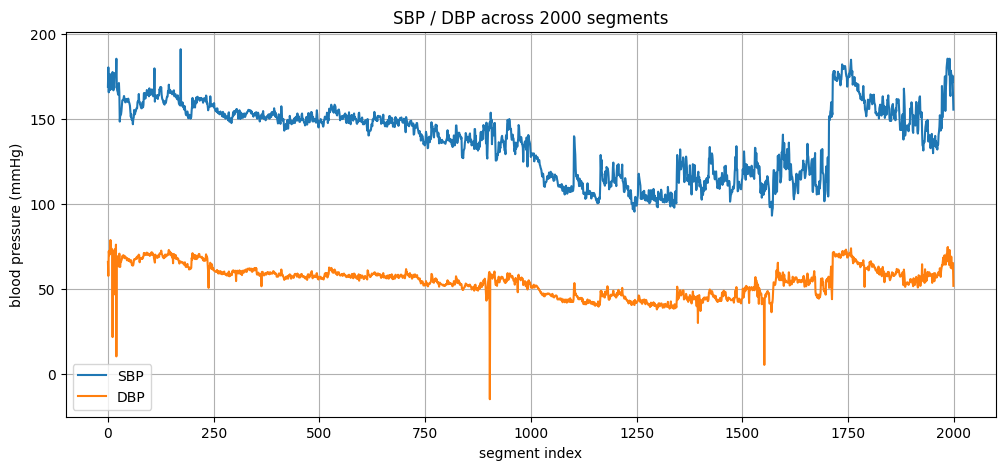

In [ ]:
# --- SBP / DBP 계산 ---
SBP, DBP = [], []
with h5py.File(mat_path, "r") as f:
    g = f["Subj_Wins"]
    abp = g["ABP_Raw"]
    seg_shape = abp.shape
    total = int(np.prod(seg_shape))
    N = min(total, 2000)  # 최대 2000세그먼트만 사용

    for i in range(N):
        idx = (0, i) if len(seg_shape)==2 and seg_shape[0]==1 else (i,)
        v = abp[idx]
        if isinstance(v, h5py.Reference):
            arr = np.ravel(f[v][()]).astype(np.float32)
            arr = arr[np.isfinite(arr)]
            if arr.size > 0:
                SBP.append(np.max(arr))
                DBP.append(np.min(arr))

SBP = np.array(SBP)
DBP = np.array(DBP)

print(f"✅ SBP/DBP 계산 완료 (seqment 수: {len(SBP)})")

# --- 시각화 ---
plt.figure(figsize=(12,5))
plt.plot(SBP, label="SBP")
plt.plot(DBP, label="DBP")
plt.xlabel("segment index")
plt.ylabel("blood pressure (mmHg)")
plt.title("SBP / DBP across 2000 segments")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

# 리스트 → numpy 배열로 변환
segments = np.array(segments, dtype=np.float32)   # (N, L)
sbp_values = np.array(sbp_values, dtype=np.float32)  # (N,)
dbp_values = np.array(dbp_values, dtype=np.float32)  # (N,)

In [ ]:
# 혹시 2000개보다 많으면 앞에서부터 2000개만 사용
N_total = segments.shape[0]
N = min(N_total, 2000)
segments = segments[:N]
sbp_values = sbp_values[:N]
dbp_values = dbp_values[:N]

print("사용할 세그먼트 개수 N:", N)
print("segments shape (raw):", segments.shape)

# CNN 입력 모양으로 변환: (N, L, 1)
if segments.ndim == 2:
    segments = segments[..., np.newaxis]

X_all = segments.astype(np.float32)                      # (N, L, 1)
y_all = np.stack([sbp_values, dbp_values], axis=-1)      # (N, 2)

N, L, C = X_all.shape
print("X_all shape:", X_all.shape)
print("y_all shape:", y_all.shape)

사용할 세그먼트 개수 N: 2000
segments shape (raw): (2000, 1250)
X_all shape: (2000, 1250, 1)
y_all shape: (2000, 2)


In [ ]:
# CNN + BiLSTM + Attention 모델 정의

import tensorflow as tf
from tensorflow.keras import layers, models

def build_cnn_bilstm_attention_model(input_length):
    """
    BP_PPG_CNN 확장 버전:
    CNN + BiLSTM + Attention 으로 SBP, DBP 동시 예측
    입력: (L, 1)
    출력: [SBP, DBP]
    """

    inputs = layers.Input(shape=(input_length, 1))

    # ----- 1) CNN Feature Extractor -----
    x = layers.Conv1D(32, kernel_size=5, padding='same', activation='relu')(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)

    x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)

    # 여기까지 shape: (time', channels)

    # ----- 2) BiLSTM -----
    # 양방향 LSTM으로 앞/뒤 문맥을 같이 봄
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
    # shape: (time', 128)

    # ----- 3) Attention Layer -----
    # 각 time step에 대해 "얼마나 중요한지" 가중치 계산
    attention_scores = layers.Dense(1, activation='tanh')(x)   # (time', 1)
    attention_scores = layers.Flatten()(attention_scores)      # (time',)
    attention_weights = layers.Activation('softmax')(attention_scores)  # 가중치 합 = 1

    # 가중치를 다시 (batch, time', 1)로 reshape해서 x에 곱해줌
    attention_weights = layers.RepeatVector(128)(attention_weights)     # (128, time')
    attention_weights = layers.Permute([2, 1])(attention_weights)       # (time', 128)

    attended = layers.Multiply()([x, attention_weights])  # (time', 128)
    attended = layers.Lambda(lambda t: tf.reduce_sum(t, axis=1))(attended)  # 가중합: (batch, 128)

    # ----- 4) 회귀 헤드 -----
    h = layers.Dense(64, activation='relu')(attended)
    h = layers.Dropout(0.3)(h)
    outputs = layers.Dense(2, activation='linear')(h)  # [SBP, DBP]

    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='mse',
        metrics=[
            tf.keras.metrics.MeanAbsoluteError(name='mae'),
            tf.keras.metrics.RootMeanSquaredError(name='rmse')
        ]
    )
    return model


In [ ]:
# 2. 순차 5-Fold 인덱스 만들기
num_folds = 5
indices = np.arange(N)

fold_sizes = np.full(num_folds, N // num_folds, dtype=int)
fold_sizes[: N % num_folds] += 1

folds = []
current = 0
for fold_size in fold_sizes:
    start = current
    end = current + fold_size
    folds.append((start, end))  # [start, end)
    current = end

print("각 fold 구간 (start, end):", folds)

각 fold 구간 (start, end): [(0, np.int64(400)), (np.int64(400), np.int64(800)), (np.int64(800), np.int64(1200)), (np.int64(1200), np.int64(1600)), (np.int64(1600), np.int64(2000))]


In [ ]:
# 3. fold마다 학습 + 검증 MAE / RMSE 계산
all_val_mae_sbp = []
all_val_mae_dbp = []
all_val_rmse_sbp = []
all_val_rmse_dbp = []

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

EPOCHS = 100
BATCH_SIZE = 32

for fold_idx, (val_start, val_end) in enumerate(folds):
    print(f"\n===== Fold {fold_idx+1}/{num_folds} =====")
    print(f"검증 구간: [{val_start} : {val_end})")

    val_indices = np.arange(val_start, val_end)
    train_indices = np.setdiff1d(indices, val_indices)

    X_train_raw = X_all[train_indices]   # (N_train, L, 1)
    y_train_raw = y_all[train_indices]   # (N_train, 2)
    X_val_raw   = X_all[val_indices]
    y_val_raw   = y_all[val_indices]

    # ------------------------------
    # (1) 입력 X 정규화: train 기준
    # ------------------------------
    # 축: (0,1) → N과 L에 대해 평균/표준편차, 채널(마지막 축)은 그대로
    X_mean = X_train_raw.mean(axis=(0, 1), keepdims=True)
    X_std  = X_train_raw.std(axis=(0, 1), keepdims=True) + 1e-8

    X_train = (X_train_raw - X_mean) / X_std
    X_val   = (X_val_raw   - X_mean) / X_std

    # ------------------------------
    # (2) 타겟 y 정규화: train 기준
    # ------------------------------
    y_mean = y_train_raw.mean(axis=0, keepdims=True)   # (1,2)
    y_std  = y_train_raw.std(axis=0, keepdims=True) + 1e-8

    y_train = (y_train_raw - y_mean) / y_std
    y_val   = (y_val_raw   - y_mean) / y_std

    print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)
    print("X_val shape  :", X_val.shape,   "y_val shape  :", y_val.shape)

    # ------------------------------
    # (3) 모델 생성 + 콜백 정의
    # ------------------------------
    model = build_cnn_bilstm_attention_model(input_length=L)

    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=7,
            restore_best_weights=True
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-6,
            verbose=1
        )
    ]

    history = model.fit(
        X_train, y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(X_val, y_val),
        shuffle=False,         # 시계열 순서 유지
        callbacks=callbacks,
        verbose=1
    )

    # ------------------------------
    # (4) 검증 세트 성능 (역정규화 후 mmHg 기준)
    # ------------------------------
    y_pred_norm = model.predict(X_val)

    # 역정규화
    y_pred = y_pred_norm * y_std + y_mean   # (N_val, 2)

    sbp_true = y_val_raw[:, 0]
    dbp_true = y_val_raw[:, 1]
    sbp_pred = y_pred[:, 0]
    dbp_pred = y_pred[:, 1]

    mae_sbp  = np.mean(np.abs(sbp_true - sbp_pred))
    mae_dbp  = np.mean(np.abs(dbp_true - dbp_pred))
    rmse_sbp = np.sqrt(np.mean((sbp_true - sbp_pred) ** 2))
    rmse_dbp = np.sqrt(np.mean((dbp_true - dbp_pred) ** 2))

    print(f"[Fold {fold_idx+1}] SBP  MAE : {mae_sbp:.3f}, RMSE : {rmse_sbp:.3f}")
    print(f"[Fold {fold_idx+1}] DBP  MAE : {mae_dbp:.3f}, RMSE : {rmse_dbp:.3f}")

    all_val_mae_sbp.append(mae_sbp)
    all_val_mae_dbp.append(mae_dbp)
    all_val_rmse_sbp.append(rmse_sbp)
    all_val_rmse_dbp.append(rmse_dbp)


===== Fold 1/5 =====
검증 구간: [0 : 400)
X_train shape: (1600, 1250, 1) y_train shape: (1600, 2)
X_val shape  : (400, 1250, 1) y_val shape  : (400, 2)
Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - loss: 0.5134 - mae: 0.5658 - rmse: 0.6899 - val_loss: 2.4080 - val_mae: 1.4857 - val_rmse: 1.5518 - learning_rate: 0.0010
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.7254 - mae: 0.7303 - rmse: 0.8404 - val_loss: 2.2471 - val_mae: 1.4328 - val_rmse: 1.4990 - learning_rate: 0.0010
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.7154 - mae: 0.7144 - rmse: 0.8349 - val_loss: 2.3189 - val_mae: 1.4549 - val_rmse: 1.5228 - learning_rate: 0.0010
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.7123 - mae: 0.7437 - rmse: 0.8372 - val_loss: 2.3344 - val_mae: 1.4590 - val_rmse: 1.5279 - learning_rate: 0.0010
Epoch 5/100
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.7048 - mae: 0.7415 - rmse: 0.8327
Epoch 5: ReduceLROnPlateau reducing learning rate t

In [ ]:
print("\n========== 5-Fold 평균 성능 (순차 분할) ==========")
print(f"SBP  MAE  평균: {np.mean(all_val_mae_sbp):.3f}")
print(f"SBP  RMSE 평균: {np.mean(all_val_rmse_sbp):.3f}")
print(f"DBP  MAE  평균: {np.mean(all_val_mae_dbp):.3f}")
print(f"DBP  RMSE 평균: {np.mean(all_val_rmse_dbp):.3f}")


========== 5-Fold 평균 성능 (순차 분할) ==========
SBP  MAE  평균: 21.065
SBP  RMSE 평균: 22.982
DBP  MAE  평균: 8.360
DBP  RMSE 평균: 9.357
